# Dive Prediction - First Time Passage

*Predicting Seabird Diving Behaviour from GPS data*

This notebook predicts dive with First Time Passage Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.dataloader import * 

In [2]:
path = "./results/SD_15s.csv"
data = pd.read_csv(path)

## Empirical parameters 

In [3]:
## compute distance matrixes
list_trip = []
for i in data.trip.unique():
    t = data[data.trip == i]

    lon = np.stack([t.lon_std for i in range(len(t))])
    lat = np.stack([t.lat_std for i in range(len(t))])
    dist = np.sqrt((lon - lon.T)**2 + (lat - lat.T)**2)
    
    list_trip.append(dist)

In [4]:
def roc(target, input):
    # globally
    TP = []
    FP = []
    
    scale = input.sort_values().unique()

    for tt in scale:
        all_estim = 1* (input > tt)
        true_positive = np.mean(all_estim[target == 1])
        true_negative = 1-np.mean(all_estim[target == 0])
        TP.append(true_positive)
        FP.append(1-true_negative)
        
    return (np.array(FP), np.array(TP))

In [5]:
def residence_time(dist, radius):
        residence_matrix = dist < radius
        residence = np.sum(residence_matrix, axis = 1)
        return residence

def first_passage_time(dist, radius):
    first_passage = np.zeros(dist.shape[0])
    residence_matrix = dist < radius
    if np.sum(residence_matrix) > 0 :
        for i in range(dist.shape[0]):
            idx = np.where(residence_matrix[:,i])[0]
            # get index start
            i_start = i
            while i_start in idx:
                i_start -=1
            # get index end
            i_end = i
            while i_end in idx:
                i_end +=1
            # get number of point
            first_passage[i] = i_end-i_start+1

    return first_passage

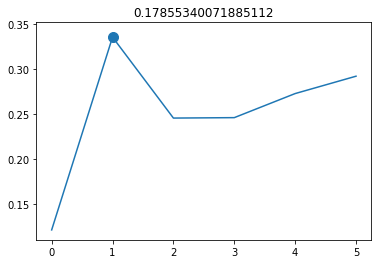

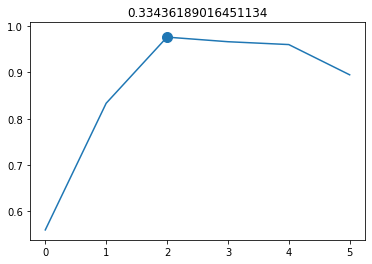

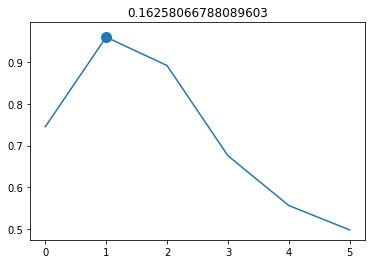

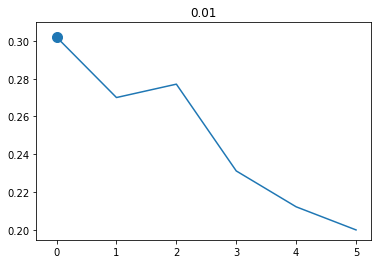

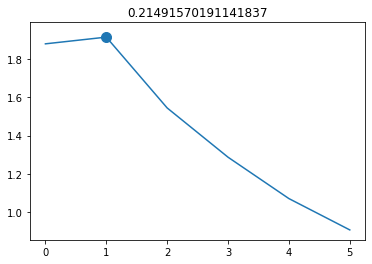

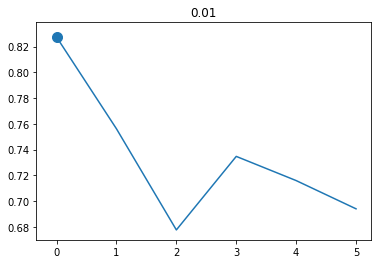

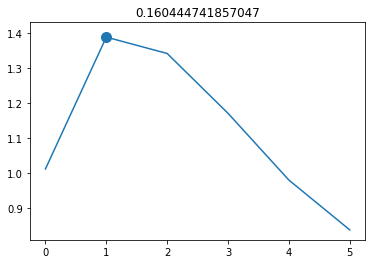

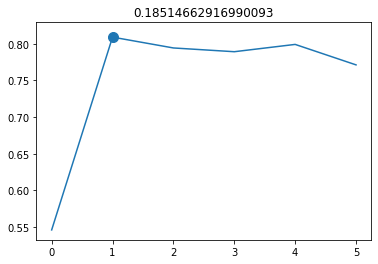

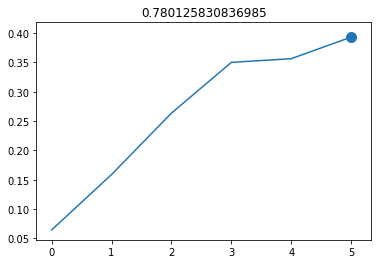

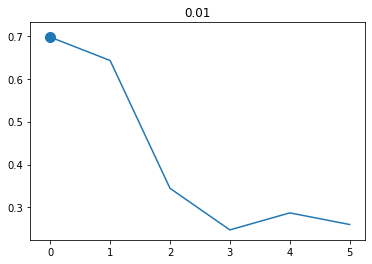

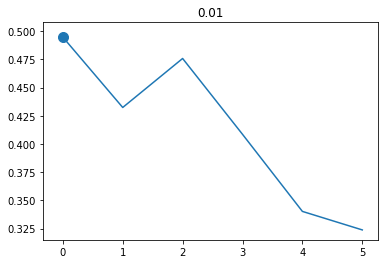

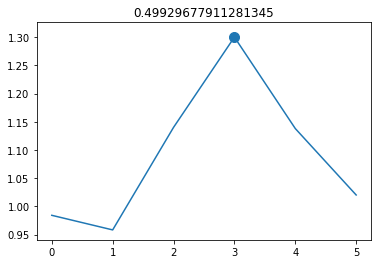

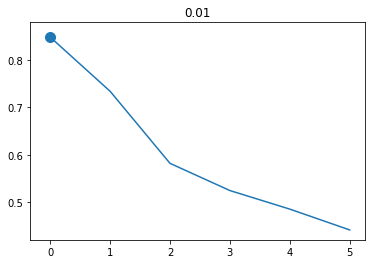

In [6]:
## compute first time passage
list_ftp = []
for dist in list_trip:
    
    ### radius selection
    radius = np.arange(0.01, np.max(dist)/5, np.max(dist)/30 )
    var = []
    for r in radius:
        ftp = first_passage_time(dist, r)
        var.append(np.var(np.log(ftp)))

    R = radius[np.argmax(var)]

    plt.plot(np.array(var))
    plt.scatter(np.argmax(var), np.max(var), s = 100)
    plt.title(R)
    plt.show()
    
    ### FPT computation
    ftp = first_passage_time(dist, R)
    ftp = ftp/max(ftp)
    ftp[ftp < 1e-5] = 1e-5
    ftp[ftp > 1-1e-5] = 1-1e-5
    
    list_ftp.append(ftp)

In [7]:
data['fpt'] = np.hstack(list_ftp)

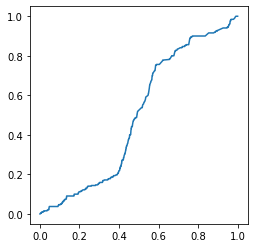

In [8]:
FP, TP = roc(data.dive, data.fpt)

plt.figure()
ax = plt.gca()
ax.set_aspect(1)

plt.plot(FP, TP)

In [9]:
data.to_csv(path, index = False)